In [1]:
# This code builds on the code provided by Jaromir Janisch, 2017

# OpenGym CartPole-v0 with A3C on GPU
# -----------------------------------
#
# A3C implementation with GPU optimizer threads.
# 
# Made as part of blog series Let's make an A3C, available at
# https://jaromiru.com/2017/02/16/lets-make-an-a3c-theory/
#
# author: Jaromir Janisch, 2017

#### Enable memory growth for GPU on Windows machines
Disable this cell if you are not on Windows or if you run on CPU only

In [2]:
import tensorflow as tf  
config = tf.ConfigProto()  
config.gpu_options.allow_growth = True  
session = tf.Session(config=config)  

#### Helper methods

In [3]:
def calc_dimensions(env):
    """Calculate dimensions based on the environment
    Halves the width and height and removes the color dimensions. 
    """
    n_actions = env.action_space.n
    obs_shape = env.observation_space.shape
    height = obs_shape[0]//2; width = obs_shape[1]//2; n_frames = 4
    state_shape = (height, width, n_frames)
    return (state_shape, n_actions)

def start(threads):
    "Helper method for starting threads"
    for thread in threads:
        thread.daemon=True
        thread.start()

def stop(threads):
    "Helper method for stopping threads"
    for thread in threads:
        thread.stop()
    for thread in threads:
        try:
            thread.join()
        except:
            pass
    

#### Imports

In [4]:
import numpy as np
import gym, time, random
import queue

from ai_agent import Agent
from ai_environment import Environment
from ai_brain import Brain
from ai_optimizer import Optimizer
from util_plotter import Plotter
from util_persistence import Persister
%matplotlib inline  

Using TensorFlow backend.


#### Constants
It is important to chose the correct amount of agents and optimizers.  
More agents usually means more stable learning becuase of the diversity in observations.  
To few optimizers will lead to too big batches, too many optimizers leads to redundancy.

In [ ]:
ENV = 'BreakoutDeterministic-v4'
RUN_TIME = 24*60*60
AGENTS = 10
OPTIMIZERS = 5
weights_name = "data/testing_code.h5"
rewards_file = 'data/testing_code.csv'

#### Main loop

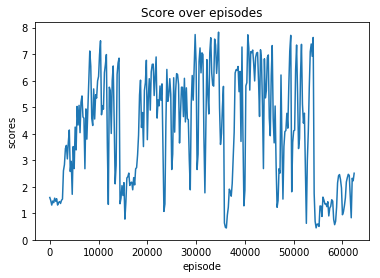

0.3


In [ ]:
#Shapes 
state_shape, actions_shape = calc_dimensions(gym.make(ENV))

# Rewards
global rewards
db = Persister(rewards_file)
rewards = db.read()

# Brain
brain = Brain(state_shape, actions_shape, model_weights=weights_name)

# Threads
exception_bucket = queue.Queue()
envs = [Environment(
            gym.make(ENV), 
            rewards, 
            Agent(brain, actions_shape, len(rewards)), 
            exception_bucket) 
        for i in range(AGENTS)]

opts = [Optimizer(brain, exception_bucket) for i in range(OPTIMIZERS)]
plotters = [Plotter(rewards, Agent(brain, actions_shape, len(rewards)))]

# Main
try:
    start(opts); start(envs); start(plotters)
    
    # Sleep for shorter periods to enable KeyBoardInterrupt
    for i in range(0, RUN_TIME, 15):
        time.sleep(15)
        
        if i % 40 == 0:
            brain.save_weights(weights_name)
            db.write(rewards) 
            
        # Shutdown if there was an exception in agent or optimizer
        try:
            e = exception_bucket.get(block=False)
            raise e
        except queue.Empty:
            pass
            
finally:
    stop(envs); stop(opts); stop(plotters)
    brain.save_weights(weights_name)
    db.write(rewards) 
    
    print("Training finished")


#### End of code